In [1]:
from IPython.display import display
import numpy as np
from scipy import sparse
import re
import matplotlib
import pandas as pd
from sklearn import linear_model
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression as LogReg
from sklearn.cross_validation import train_test_split
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cmx
import matplotlib.colors as colors
import datetime as dt
import math
from sklearn.linear_model import Lasso as Lasso_Reg
import numpy as np 
import sklearn.preprocessing as Preprocessing
from sklearn.preprocessing import StandardScaler as Standardize
%matplotlib inline
from sklearn.linear_model import LinearRegression as Lin_Reg
from sklearn.linear_model import Ridge as Ridge_Reg
from sklearn.ensemble import GradientBoostingRegressor as GBR
from scipy.stats.mstats import winsorize
from sklearn.metrics import mean_squared_error

In [2]:
df_x = pd.read_csv('attractions_added.csv')

In [6]:
df_y = pd.read_csv('log_prices.csv')

In [7]:
#method to evaluate advanced models in comparison to the baseline. This will require the advanced models to be coded in
#the same style as sklearn models

def missed_points(model,dataframe,target):
    # split x and y into train and test
    x_train, x_test, y_train, y_test = train_test_split(dataframe, target['price'], test_size = 0.3)

    #standardize x_train and y_train
    std = Standardize(with_mean=False)
    x_train_std = std.fit_transform(x_train)
    x_test_std = x_test / std.scale_ 
    
    # perform multivariate regression
    clf = Lin_Reg()
    clf.fit(x_train_std, y_train)
    
    #model prediction
    adv = model()
    adv.fit(x_train_std, y_train)
    
    #compare models
    lin_predict = clf.predict(x_test_std)
    adv_predict = adv.predict(x_test_std)
    
    y_test = pd.DataFrame(y_test)
    y_test.columns = ['price']
    y_test['lin_predict'] = lin_predict
    y_test['adv_predict'] = adv_predict
    
    y_test['score'] = 0.0
    mask = y_test.loc[abs(y_test['price'] - y_test['adv_predict']) < abs(y_test['price'] - y_test['lin_predict'])].index
    missed_x = x_test.loc[mask]
    missed_y = y_test.loc[mask]
    return missed_x,missed_y,x_test,y_test

In [8]:
miss_df,miss_target,x_test,y_test = missed_points(GBR,df_x,df_y)

In [9]:
miss_df.shape

(3283, 224)

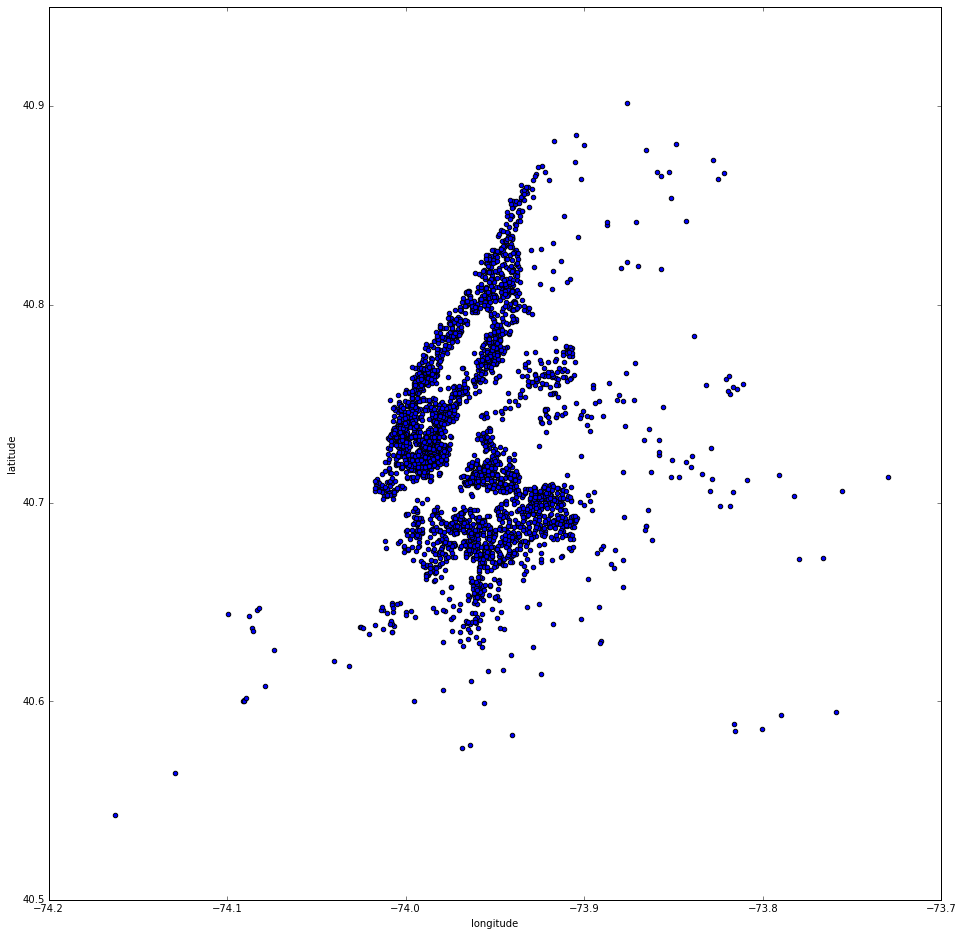

In [10]:
#data points where the advanced model did not outpredict the baseline
miss_df.plot.scatter(x='longitude',y='latitude',figsize=(16,16))

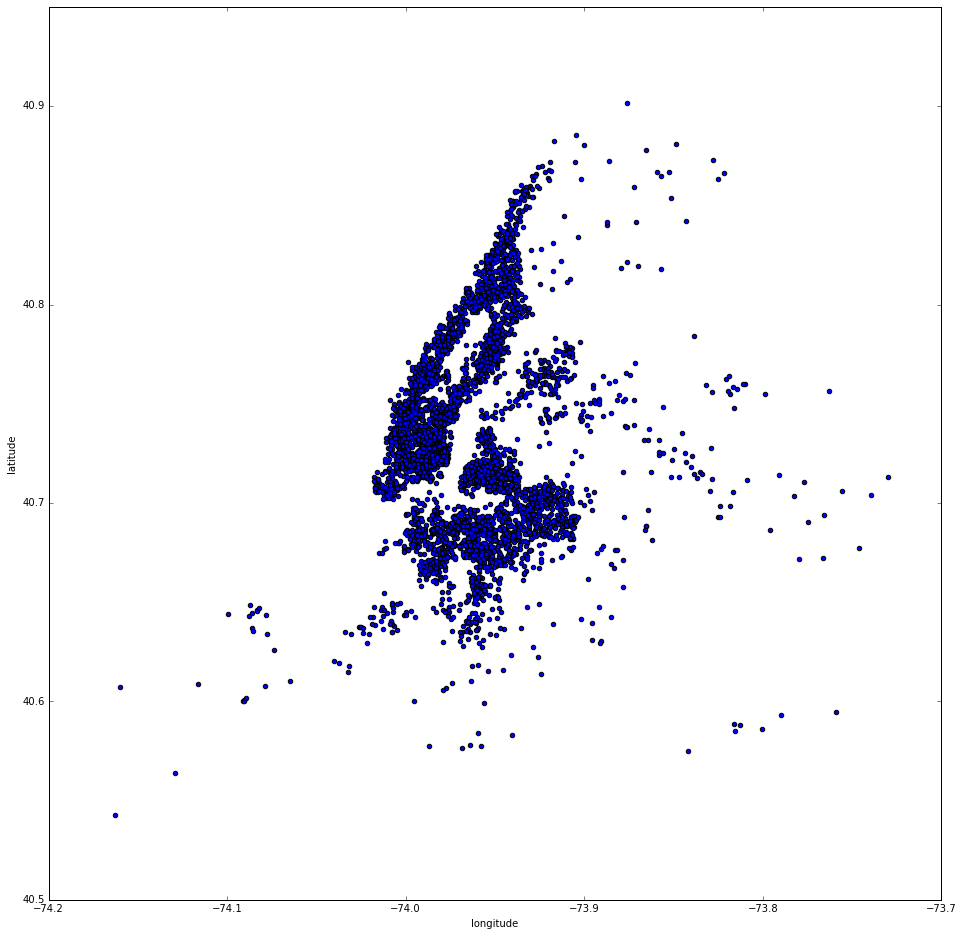

In [11]:
#plotting every point in the test set
x_test.plot.scatter(x='longitude',y='latitude',figsize=(16,16))

In [12]:
miss_df.shape[0]/x_test.shape[0]

0.6072881982981873

In [13]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

n_missdf = miss_df.select_dtypes(include=numerics)
n_fulldf = x_test.select_dtypes(include=numerics)

In [14]:
miss_mean = n_missdf.mean()

In [15]:
all_mean = n_fulldf.mean()

In [16]:
diff_means = all_mean-miss_mean

In [17]:
diff_means.shape

(224,)

In [29]:
display(diff_means)

Allerton                       0.000000
Alphabet City                  0.000538
Astoria                       -0.000188
Bath Beach                    -0.000127
Battery Park City              0.000086
Bay Ridge                      0.000466
Baychester                     0.000428
Bayside                        0.000000
Bedford Park                  -0.000127
Bedford-Stuyvesant            -0.008950
Bensonhurst                   -0.000069
Bergen Beach                   0.000000
Boerum Hill                    0.001555
Borough Park                   0.000000
Brighton Beach                -0.000380
Bronxdale                     -0.000127
Brooklyn                      -0.000380
Brooklyn Heights               0.000562
Brooklyn Navy Yard             0.000534
Bushwick                      -0.009255
Canarsie                       0.000116
Carroll Gardens                0.001466
Castle Hill                    0.000000
Chelsea                        0.000059
Chinatown                      0.005964


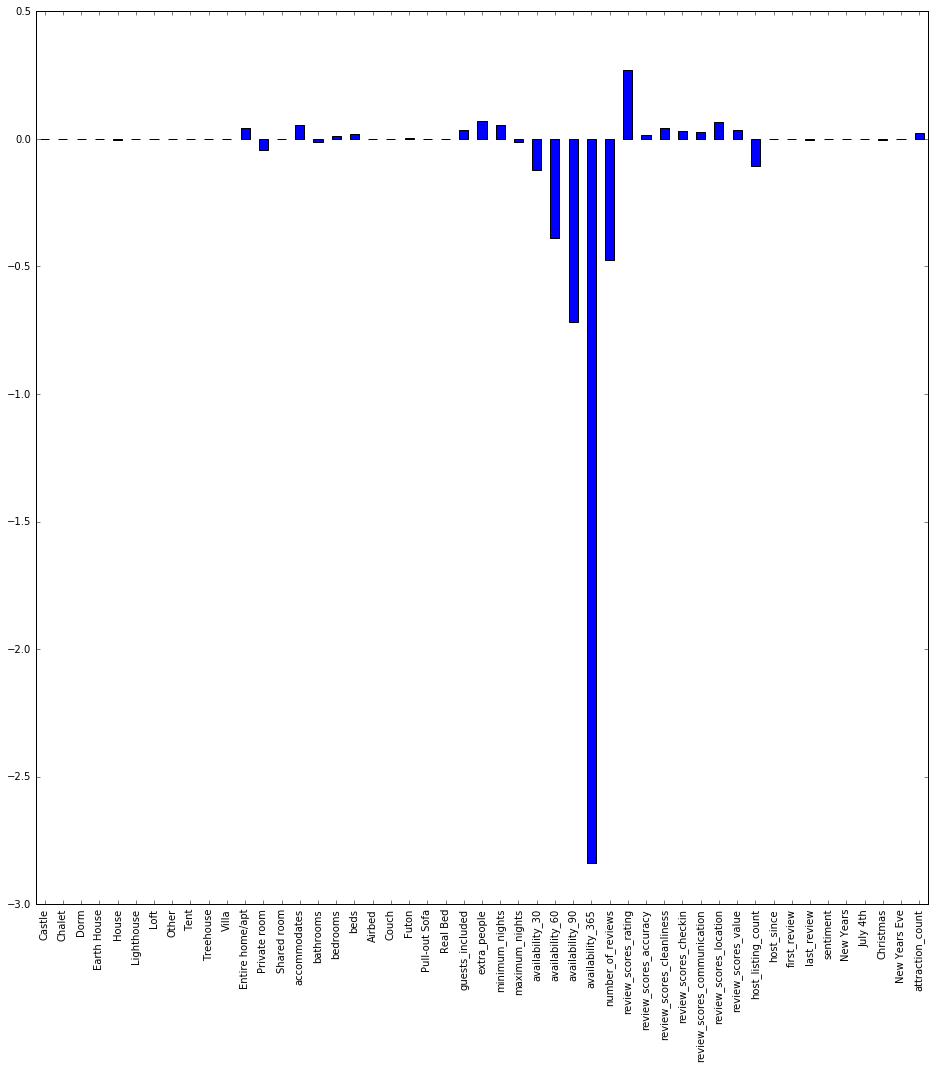

In [21]:
diff_means[175:224].plot.bar(figsize=(16,16))

These differences look pretty good. It is not too concerning that availability 365 is ~4 off.

In [31]:
x_test.availability_365.mean()

272.44654088050316

In [32]:
miss_df.availability_365.mean()

276.0498753117207

In [22]:
def error_feat(model,dataframe,target):
    # split x and y into train and test
    x_train, x_test, y_train, y_test = train_test_split(dataframe, target['price'], test_size = 0.3)

    #standardize x_train and y_train
    std = Standardize(with_mean=False)
    x_train_std = std.fit_transform(x_train)
    x_test_std = x_test / std.scale_ 
    
    #perform multivariate regression
    clf = Lin_Reg()
    clf.fit(x_train_std, y_train)
    
    #model prediction
    adv = model()
    adv.fit(x_train_std, y_train)
    
    #compare models
    lin_predict = clf.predict(x_test_std)
    adv_predict = adv.predict(x_test_std)

    x_test['price'] = y_test

    l_error = (lin_predict-x_test.price)**2
    a_error = (adv_predict-x_test.price)**2
    
    x_test['price'] = y_test
    x_test['lin_predict'] = lin_predict
    x_test['adv_predict'] = adv_predict
    x_test['l_error'] = l_error
    x_test['a_error'] = a_error

    
    y_test['score'] = 0.0
    mask = x_test.loc[abs(x_test['price'] - x_test['adv_predict']) < abs(x_test['price'] - x_test['lin_predict'])].index
    missed_x = x_test.loc[mask]
    missed_y = y_test.loc[mask]
    return missed_x,missed_y,x_test,y_test

In [23]:
missed_x,missed_y,x_test,y_test = error_feat(GBR,df_x,df_y)

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

In [33]:
neighborhoods = ["Allerton",
"Alphabet City",
"Astoria",
"Bath Beach",
"Battery Park City",
"Bay Ridge",
"Baychester",
"Bayside",
"Bedford Park",
"Bedford-Stuyvesant",
"Bensonhurst",
"Bergen Beach",
"Boerum Hill",
"Borough Park",
"Brighton Beach",
"Bronxdale",
"Brooklyn",
"Brooklyn Heights",
"Brooklyn Navy Yard",
"Bushwick",
"Canarsie",
"Carroll Gardens",
"Castle Hill ",
"Chelsea",
"Chinatown",
"City Island",
"Civic Center",
"Claremont",
"Clifton",
"Clinton Hill",
"Cobble Hill",
"College Point",
"Columbia Street Waterfront",
"Concord",
"Concourse",
"Concourse Village",
"Coney Island",
"Corona",
"Country Club",
"Crotona",
"Crown Heights",
"DUMBO",
"Ditmars / Steinway",
"Downtown Brooklyn",
"Dyker Heights",
"East Elmhurst",
"East Flatbush",
"East Harlem",
"East New York",
"East Village",
"Eastchester",
"Elm Park",
"Elmhurst",
"Eltingville",
"Financial District",
"Flatbush",
"Flatiron District",
"Flatlands",
"Flushing",
"Fordham",
"Forest Hills",
"Fort Greene",
"Glendale",
"Gowanus",
"Gramercy Park",
"Graniteville",
"Grasmere",
"Gravesend",
"Greenpoint",
"Greenwich Village",
"Greenwood Heights",
"Hamilton Heights",
"Harlem",
"Hell's Kitchen",
"Highbridge",
"Hillcrest",
"Howard Beach",
"Hudson Square",
"Inwood",
"Jackson Heights",
"Jamaica",
"Kensington",
"Kew Garden Hills",
"Kingsbridge Heights",
"Kips Bay",
"Lefferts Garden",
"Little Italy",
"Long Island City",
"Longwood",
"Lower East Side",
"Manhattan",
"Marble Hill",
"Mariners Harbor",
"Maspeth",
"Meatpacking District",
"Meiers Corners",
"Melrose",
"Middle Village",
"Midtown",
"Midtown East",
"Midwood",
"Morningside Heights",
"Morris Park",
"Morrisania",
"Mott Haven",
"Mount Eden",
"Murray Hill",
"New Brighton",
"New Dorp",
"New Dorp Beach",
"Noho",
"Nolita",
"Norwood",
"Oakwood",
"Ozone Park",
"Park Slope",
"Park Versailles",
"Pelham Bay",
"Port Morris",
"Prospect Heights",
"Queens",
"Randall Manor",
"Red Hook",
"Rego Park",
"Richmond Hill",
"Ridgewood",
"Riverdale",
"Roosevelt Island",
"Rosebank",
"Sheepshead Bay",
"Soho",
"Soundview",
"South Beach",
"South Ozone Park",
"South Street Seaport",
"Spuyten Duyvil",
"St. George",
"Stapleton",
"Staten Island",
"Sunnyside",
"Sunset Park",
"The Bronx",
"The Rockaways",
"Throgs Neck",
"Times Square/Theatre District",
"Todt Hill",
"Tompkinsville",
"Tottenville",
"Tremont",
"Tribeca",
"Union Square",
"University Heights",
"Upper East Side",
"Upper West Side",
"Utopia",
"Van Nest",
"Vinegar Hill",
"Washington Heights",
"West Brighton",
"West Village",
"Westchester Village",
"Westerleigh",
"Whitestone",
"Williamsbridge",
"Williamsburg",
"Windsor Terrace",
"Woodhaven",
"Woodlawn",
"Woodside"]

In [34]:
neighb_list = []
for neighb in neighborhoods:
    neighb_set = x_test[x_test[neighb]==1.0]
    if neighb_set.shape[0] > 0:
        neighb_set_size = neighb_set.shape[0]
        neighb_sum_l = neighb_set.l_error.sum()/neighb_set_size
        neighb_sum_m = neighb_set.a_error.sum()/neighb_set_size
        neighb_list.append((neighb,neighb_sum_l,neighb_sum_m))

In [35]:
neighb_list=pd.DataFrame(neighb_list,columns=['neighborhood','neighb_sum_l','neighb_sum_m'])

In [36]:
neighb_list.set_index('neighborhood',inplace=True)

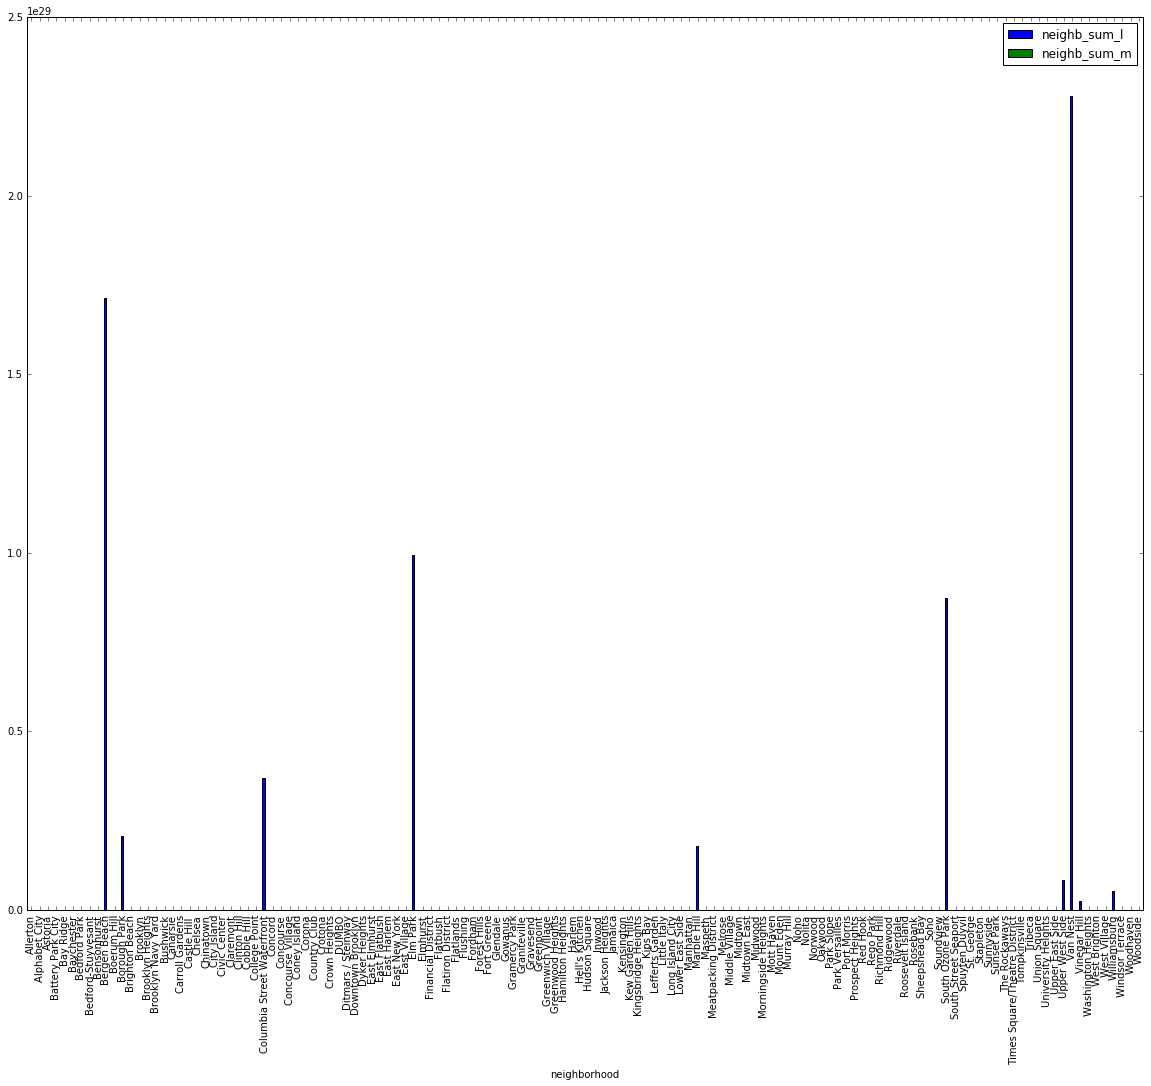

In [37]:
neighb_list.plot.bar(figsize=(20,16))

In [38]:
van_nest = df_x[df_x['Van Nest']==1.0]

In [39]:
van_nest.shape

(1, 224)

Some neighborhoods with low n in the test set were way off. This was only for the baseline model, however. The advanced model (Gradient Boosting in this case) did not have the same problem.

In [40]:
categorical =["Apartment",
"Bed & Breakfast",
"Boat",
"Cabin",
"Castle",
"Chalet",
"Dorm",
"Earth House",
"House",
"Lighthouse",
"Loft",
"Other",
"Tent",
"Treehouse",
"Villa",
"Entire home/apt",
"Private room",
"Shared room",
"accommodates",
"bathrooms",
"bedrooms",
"beds",
"Airbed",
"Couch",
"Futon",
"Pull-out Sofa",
"Real Bed",
"guests_included",
"extra_people",
"New Years",
"July 4th",
"Christmas",
"New Years Eve"]

In [41]:
cat_list = []
for cat in categorical:
    neighb_set = x_test[x_test[cat]==1.0]
    if neighb_set.shape[0] > 0:
        neighb_set_size = neighb_set.shape[0]
        neighb_sum_l = neighb_set.l_error.sum()/neighb_set_size
        neighb_sum_m = neighb_set.a_error.sum()/neighb_set_size
        cat_list.append((cat,neighb_sum_l,neighb_sum_m))

In [42]:
cat_list = pd.DataFrame(cat_list,columns=['cat','neighb_sum_l','neighb_sum_m'])

In [43]:
cat_list.set_index('cat',inplace=True)

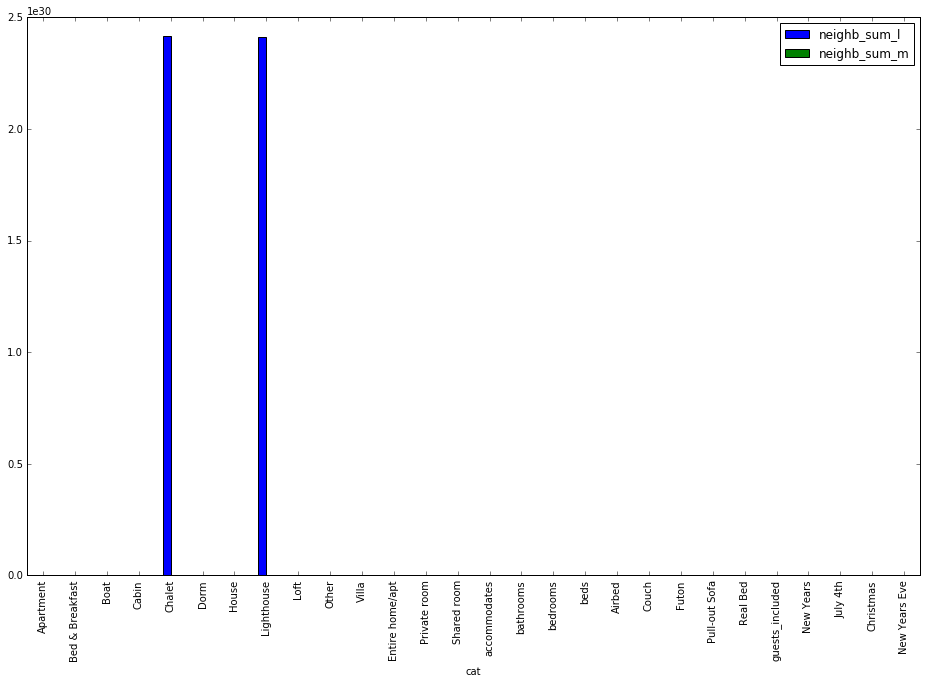

In [49]:
cat_list.plot.bar(figsize=(16,10))

In [48]:
df_x[df_x.Chalet==1.0].shape

(1, 224)

Similarly, variables with small n were somtimes wildly off. Again, this was only a problem for the baseline model. This goes to show that the Gradient Boosting model has an advantage in that it doesn't make wildly inaccurate predictions.